In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

import pickle
from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['Body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'Body': map_to_list(emails, 'Body'), 
    }
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [77]:
adf = pd.read_csv("input621new.csv",  engine='python', encoding='utf-8', error_bad_lines=False)
df = pd.DataFrame(parse_into_emails(adf.Body))
df

C:\Users\PC\AppData\Local\Temp\ipykernel_23272\1448670070.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  adf = pd.read_csv("input621new.csv",  engine='python', encoding='utf-8', error_bad_lines=False)


,Body
0,SUTDFam!!Having trouble deciding what mods to ...
1,",Once you have filled in the form, we will hav..."
2,"Students,SUTD will be changing the name of its..."
3,________________________________Parul Kapur <P...
4,"Student Reps,Thank you for your mitment and co..."
...,...
655,Meeting details are as follows.
656,Meeting details are as follows.
657,Event details are as follows.
658,Event details are as follows.


In [78]:
# df['Body'] = df['Body'].astype(str)
# df['Body'] = df['Body'].apply(lambda x: x.lower())
# punctuations = '\.\!\?'
# df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
# df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
# df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
# #print(type(df['Body']))
# #df.applymap(type)
# df['Body'] = df['Body'].astype(str)
# df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
# stop = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'enron'])
# df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# df

In [79]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,2),
                     stop_words=stop,
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

d:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
d:\Python\Python310\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


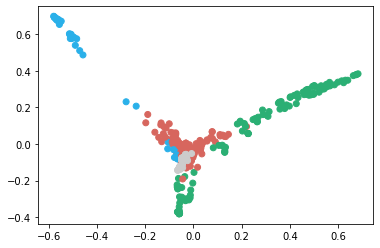

In [80]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 4
clf = KMeans(n_clusters=n_clusters, max_iter=500, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# labels = clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





In [81]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

           features     score
0         interview  0.758495
1              yang  0.209010
2            keegan  0.188811
3      sutd request  0.144827
4       sutd keegan  0.136961
5       keegan kang  0.134772
6  keegan_kang sutd  0.130859
7       keegan_kang  0.130859
8  kang keegan_kang  0.130859
9       participate  0.125874


d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

        features     score
0        meeting  0.016181
1            art  0.015728
2             pm  0.014337
3        housing  0.013583
4           join  0.013532
5          event  0.013257
6            kit  0.012790
7         2fsutd  0.012634
8          class  0.012123
9  reimbursement  0.011860


In [83]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    print(y)
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 0 2 2 2 2 2 2 2
 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 2 0 0 2 2 0 1 2 0 0 0 0 1 1 0 2 0 0 2 0 0 0 1 2 0 0 0 2 1 0 2 2 0 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 0 0 2 2 0 0 0 0 2 2 0 0 0 2 2 0 0
 2 2 2 2 0 2 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 1 1 2 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 2 2 2 2 0 0 0 2 0 2 2 0 2 2 2 0 0 2 0 2 0 2 2 1 0 0 1 0
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 0 2 0 2 2 0 1 2 1 2 1 2 2 2 0 1 2 0 2 2 2 2 1 2 1 1 2 0 2 0 2 2 2 1
 2 2 2 2 2 1 2 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 0 2 2
 2 1 1 1 1 2 1 2 1 2 0 1 2 1 2 2 2 2 1 2 2 2 2 2 0 2 2 1 1 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 

d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[        features     score
 0            art  0.124110
 1            kit  0.112100
 2         2fsutd  0.110770
 3  reimbursement  0.109001
 4    2fsutd data  0.089995
 5            www  0.080090
 6        housing  0.073501
 7  sutdsingapore  0.069524
 8        art kit  0.067741
 9           test  0.066482,
           features     score
 0           devans  0.055315
 1         intended  0.051285
 2           events  0.048756
 3  studentgov sutd  0.047519
 4       studentgov  0.047519
 5          message  0.043559
 6       devans jos  0.040680
 7              jos  0.039378
 8              wei  0.027009
 9          singnet  0.023271,
     features     score
 0       zoom  0.018543
 1      class  0.014170
 2   students  0.013635
 3    session  0.012727
 4     cohort  0.012705
 5        org  0.012652
 6       term  0.011604
 7       life  0.011397
 8       week  0.011215
 9  singapore  0.009858,
           features     score
 0               pm  0.132292
 1          meeting  0.127876
 2   

[2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 0 2 2 2 2 2 2 2
 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 2 0 0 2 2 0 1 2 0 0 0 0 1 1 0 2 0 0 2 0 0 0 1 2 0 0 0 2 1 0 2 2 0 2
 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 0 0 2 2 0 0 0 0 2 2 0 0 0 2 2 0 0
 2 2 2 2 0 2 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 1 1 2 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 2 2 2 2 0 0 0 2 0 2 2 0 2 2 2 0 0 2 0 2 0 2 2 1 0 0 1 0
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 0 2 0 2 2 0 1 2 1 2 1 2 2 2 0 1 2 0 2 2 2 2 1 2 1 1 2 0 2 0 2 2 2 1
 2 2 2 2 2 1 2 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 1 2 0 2 2 2 2 2 2 2 2 0 2 2
 2 1 1 1 1 2 1 2 1 2 0 1 2 1 2 2 2 2 1 2 2 2 2 2 0 2 2 1 1 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 

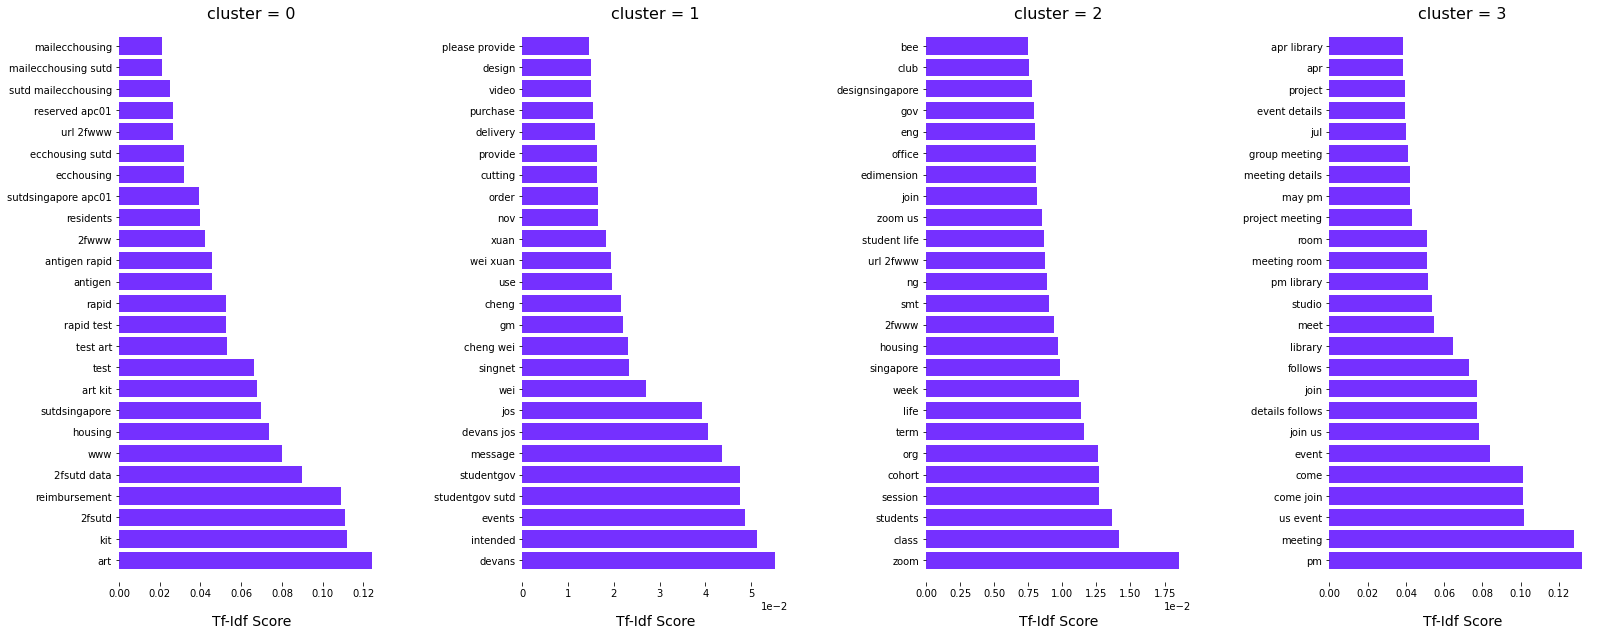

In [84]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [85]:
# km = KMeans(n_clusters=5).fit(df)

# cluster_map = pd.DataFrame()
# cluster_map['data_index'] = df.index.values
# cluster_map['cluster'] = clf.labels_

# cluster_map[cluster_map.cluster == 2]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
#df.loc[df[clf.labels_==0], 'Meetings'] = df.Categories 
#df.loc = df[clf.labels_==0]['Categories'].fillna('Meeting')
#df['Categories'][mask] = "Meeting"
#df.loc[df[clf.labels_==0], 'Categories'] = 'Meeting'

df['Classifications'] = pd.Series(labels, index=df.index)
# df_new = df[df['Classifications'] != 1]
# df_new

df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = '\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
# stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

X = df['Body']
y = pd.to_numeric(df['Classifications'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

df

In [86]:
# count every word/phrase and put it into a matrix
vect = TfidfVectorizer(ngram_range=(1,3),
                     stop_words=stop,
                     min_df = 5,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
d:\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


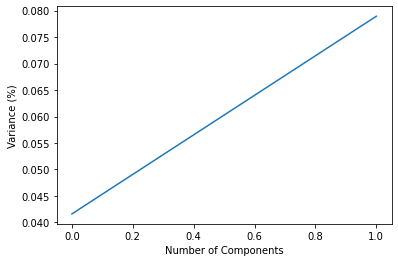

In [87]:
# converting sparse matrices into dense matrices
# replace empty spaces in the matrices with 0 (some sentences might not have a specific word)
X_train_dense = pd.DataFrame(X_train_dtm.toarray(), columns = vect.get_feature_names())
X_test_dense = pd.DataFrame(X_test_dtm.toarray(), columns = vect.get_feature_names())

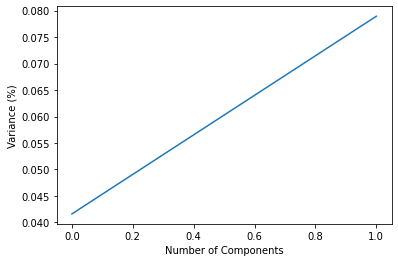

In [88]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

In [89]:
pca = PCA(n_components = 250) # put a reasonable number from graph (70%-90%)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, criterion="entropy", n_jobs=-1, random_state=0)
rfc.fit(X_train_pca, y_train)
predictions = rfc.predict(X_test_pca)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[126   0   0   0]
 [  0  19   0   0]
 [  0   0   6   0]
 [  2   0   0  12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       126
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00         6
           3       1.00      0.86      0.92        14

    accuracy                           0.99       165
   macro avg       1.00      0.96      0.98       165
weighted avg       0.99      0.99      0.99       165



In [91]:
cm1 = confusion_matrix(y_test, predictions)
print("Confusion Matrix : \n", cm1)
total1 = sum(sum(cm1))

accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print("Accuracy :", accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print("Sensitivity :", sensitivity1)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("Specificity :", specificity1)

Confusion Matrix : 
 [[126   0   0   0]
 [  0  19   0   0]
 [  0   0   6   0]
 [  2   0   0  12]]
Accuracy : 0.8787878787878788
Sensitivity : 1.0
Specificity : 1.0


In [92]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=500)
mlp.fit(X_train_pca,y_train)
y_pred_class = mlp.predict(X_test_pca)
print(y_pred_class)

[0 0 0 0 1 3 0 0 0 1 1 0 0 0 0 1 2 0 0 0 0 0 0 1 0 0 1 0 3 0 0 0 0 0 0 2 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 1 1
 0 0 0 0 0 0 0 0 1 1 3 0 3 0 0 0 0 3 0 0 3 3 0 0 0 2 1 1 0 0 0 0 0 0 1 3 3
 0 0 0 3 0 1 0 0 0 0 0 3 0 0 0 1 1 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 2 0 0 1 0 0 0 0 0 0 3 0 0 0 0 0]


In [93]:
cm1 = confusion_matrix(y_test,y_pred_class)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[
    
    1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[126   0   0   0]
 [  0  19   0   0]
 [  0   0   6   0]
 [  0   0   0  14]]
Accuracy :  0.8787878787878788
Sensitivity :  1.0
Specificity :  1.0


In [94]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
# pickle.dump(mlp, open('model.pkl','wb'))
# print(X_test_pca)
# # Loading model to compare the results
# model = pickle.load(open('model.pkl','rb'))
# print(model.predict(X_test_pca))